In [30]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

input_x1 = pd.read_csv('df1_smallestdata.csv')
input_x2 = pd.read_csv('df2_smallestdata.csv')
target_y = pd.read_csv('targets_smallestdata.csv')
input_x1 = input_x1.drop(columns=['ResponseID', 'CrossingSignal', 'NumberOfCharacters', 'Saved', 'LeftHand'])
input_x2 = input_x2.drop(columns=['ResponseID', 'CrossingSignal', 'NumberOfCharacters', 'Saved', 'LeftHand'])
feature_names = input_x1.columns.tolist()  # Get feature names from the DataFrame

input_x1 = input_x1.to_numpy()
input_x2 = input_x2.to_numpy()
target_y = target_y.to_numpy()


In [31]:
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 9)
        self.fc3 = nn.Linear(9, 3)
        self.fc4 = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)



    def forward(self, x1, x2):
        # Element-wise subtraction
        x = x1 - x2
        # Forward pass with shared weights
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

    def loss(self, output, target):
        return self.criterion(output, target)

    def backward(self, loss):
        loss.backward()

    def train_step(self, x1, x2, target):
        # Forward pass
        output = self.forward(x1, x2)
        # Compute the loss
        loss = self.loss(output, target)
        # Zero the gradients
        self.optimizer.zero_grad()
        # Backward pass
        self.backward(loss)
        # Update the weights
        self.optimizer.step()
        return loss



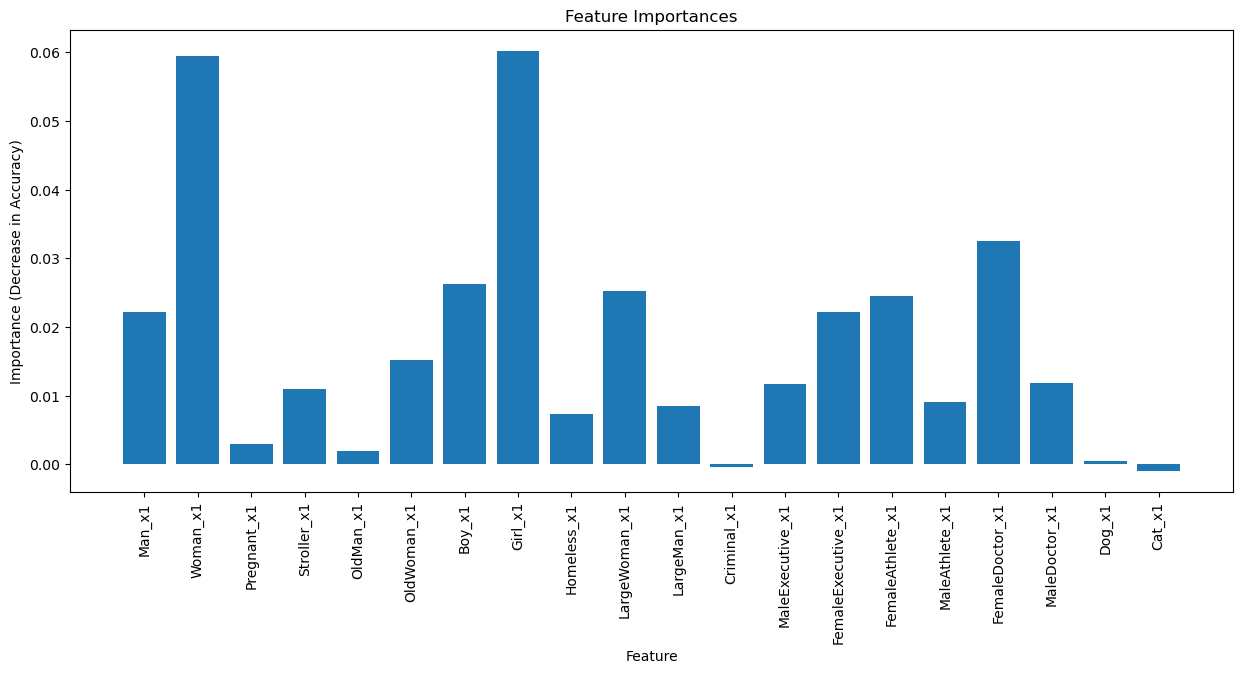

In [51]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import random
import matplotlib.pyplot as plt

num_permutations = 1000

#load the trained PyTorch model
model_path = 'trained_sample.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
model.eval()

X_test1 = torch.tensor(input_x1, dtype=torch.float32)
X_test2 = torch.tensor(input_x2, dtype=torch.float32)
y_test = torch.tensor(target_y, dtype=torch.float32)

device = torch.device('cpu')  # or 'cuda' if using GPU
X_test1 = X_test1.to(device)
X_test2 = X_test2.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    original_accuracy = accuracy_score(y_test.cpu().numpy(), model(X_test1, X_test2).cpu().numpy().round())

summed_importances = {}

# Perform permutations
for _ in range(num_permutations):
    for feature in range(X_test1.shape[1]):
        #permute X_test1
        X_test1_permuted = X_test1.clone().detach()
        X_test1_permuted[:, feature] = X_test1_permuted[torch.randperm(X_test1_permuted.size(0))][:, feature]

        #permute X_test2
        X_test2_permuted = X_test2.clone().detach()
        X_test2_permuted[:, feature] = X_test2_permuted[torch.randperm(X_test2_permuted.size(0))][:, feature]

        with torch.no_grad():
            permuted_output_x1 = model(X_test1_permuted, X_test2).cpu().numpy().round()
            permuted_accuracy_x1 = accuracy_score(y_test.cpu().numpy(), permuted_output_x1)
            permuted_output_x2 = model(X_test1, X_test2_permuted).cpu().numpy().round()
            permuted_accuracy_x2 = accuracy_score(y_test.cpu().numpy(), permuted_output_x2)

        summed_importances[f'x1_feature_{feature}'] = summed_importances.get(f'x1_feature_{feature}', 0) + (original_accuracy - permuted_accuracy_x1)
        summed_importances[f'x2_feature_{feature}'] = summed_importances.get(f'x2_feature_{feature}', 0) + (original_accuracy - permuted_accuracy_x2)

feature_importances = {key: value / num_permutations for key, value in summed_importances.items()}

#feature indices to actual names
num_features_x1 = len(feature_names)
combined_feature_names = [f"{name}_x1" for name in feature_names] + [f"{name}_x2" for name in feature_names]
updated_feature_importances = {combined_feature_names[int(key.split('_')[-1])]: value for key, value in feature_importances.items()}

# Plotting the feature importances with actual feature names
plt.figure(figsize=(15, 6))
plt.bar(updated_feature_importances.keys(), updated_feature_importances.values())
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (Decrease in Accuracy)')
plt.title('Feature Importances')
plt.show()

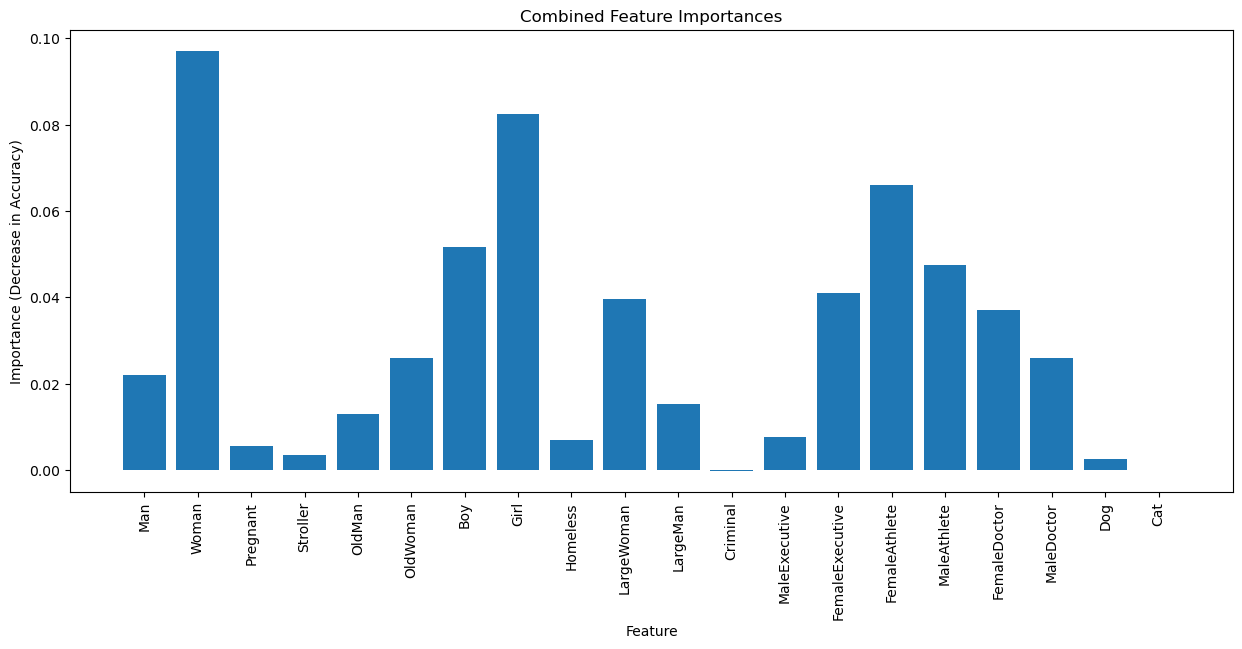

In [50]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import random
import matplotlib.pyplot as plt

model_path = 'trained_sample.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
model.eval()

X_test1 = torch.tensor(input_x1, dtype=torch.float32)
X_test2 = torch.tensor(input_x2, dtype=torch.float32)
y_test = torch.tensor(target_y, dtype=torch.float32)

#tensors to the device
device = torch.device('cpu')  # or 'cuda' if using GPU
X_test1 = X_test1.to(device)
X_test2 = X_test2.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    original_accuracy = accuracy_score(y_test.cpu().numpy(), model(X_test1, X_test2).cpu().numpy().round())

num_permutations = 1000

summed_importances = {}

for _ in range(num_permutations):
    for feature in range(X_test1.shape[1]):
        #clone and shuffle the same feature in both X_test1 and X_test2
        X_test1_permuted = X_test1.clone().detach()
        X_test2_permuted = X_test2.clone().detach()
        shuffled_indices = torch.randperm(X_test1_permuted.size(0))
        X_test1_permuted[:, feature] = X_test1_permuted[shuffled_indices][:, feature]
        X_test2_permuted[:, feature] = X_test2_permuted[shuffled_indices][:, feature]

        #accuracy with the permuted data
        with torch.no_grad():
            permuted_output = model(X_test1_permuted, X_test2_permuted).cpu().numpy().round()
            permuted_accuracy = accuracy_score(y_test.cpu().numpy(), permuted_output)

        summed_importances[feature] = summed_importances.get(feature, 0) + (original_accuracy - permuted_accuracy)

#avg the summed importances
feature_importances = {feature: value / num_permutations for feature, value in summed_importances.items()}

updated_feature_importances = {feature_names[key]: value for key, value in feature_importances.items()}

plt.figure(figsize=(15, 6))
plt.bar(updated_feature_importances.keys(), updated_feature_importances.values())
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (Decrease in Accuracy)')
plt.title('Combined Feature Importances')
plt.show()
